In [18]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
import os
import pickle

pd.set_option('display.max_columns', None)


# Load the dataset from backoffice
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

pueblos_cmun = df_pueblos['cmun'].tolist()

# Load the dataset from user chosen villages
user_files = os.listdir("../../data/user_output/")

user_choices = []

# Get all files from the user_output directory

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

# user choices of first user
user_choices_cmun = user_choices[0].cmun.tolist()
display(pueblos_cmun)
display(user_choices_cmun)

[15061,
 27025,
 27013,
 15025,
 33070,
 27063,
 15076,
 33021,
 33023,
 27038,
 15049,
 33039,
 15081,
 27005,
 33069,
 27002,
 33017,
 33018,
 15055,
 33030,
 33019,
 39047,
 39006,
 27027,
 39011,
 27033,
 33074,
 33056,
 15051,
 39005,
 39043,
 39061,
 33013,
 27061,
 33077,
 33010,
 39029,
 33007,
 27030,
 48012,
 39044,
 39009,
 33009,
 15015,
 39040,
 33054,
 48056,
 33065,
 33059,
 33063,
 39062,
 48068,
 48014,
 48077,
 48031,
 39031,
 33042,
 48076,
 39036,
 48048,
 39076,
 39080,
 39024,
 48021,
 48061,
 39068,
 48028,
 39028,
 39084,
 48089,
 39095,
 39099,
 33055,
 33045,
 39038,
 39001,
 27001,
 48064,
 48040,
 48049,
 33071,
 27054,
 33040,
 48033,
 39102,
 27021,
 48908,
 39030,
 48053,
 48041,
 39048,
 27048,
 48913,
 48063,
 15091,
 39002,
 39037,
 48010,
 39064,
 39090,
 48907,
 33043,
 48906,
 48047,
 33029,
 33006,
 39091,
 48035,
 48004,
 15050,
 15043,
 39018,
 48909,
 33046,
 48079,
 48018,
 39019,
 48903,
 48038,
 48914,
 33075,
 33047,
 39033,
 33057,
 20056,


[15016, 4016, 9259, 20004, 21079]

In [19]:
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Process user choices: filter for encoded features and remove binary columns
processed_user_choices = []
for df in user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    processed_user_choices.append(df_non_binary)

display(processed_user_choices[0])
display(pueblos_numerical_features)


,enc_scaled__total_population,enc_scaled__female,enc_scaled__score_connectivity,enc_scaled__score_economy,enc_scaled__score_area_economy,enc_scaled__score_hospital_distance,enc_scaled__score_area_hospital,enc_scaled__score_school_distance,enc_scaled__score_area_school,enc_scaled__score_transport,enc_scaled__score_age
0,3.278594,3.374256,0.508191,3.868216,3.868216,0.268855,0.268855,0.719746,0.719746,1.424676,-0.068612
1,1.976158,1.856187,0.662864,2.137206,2.137206,0.268855,0.268855,0.719746,0.719746,1.480792,1.374778
2,-0.536638,-0.559137,0.770321,-0.400296,-0.400296,1.043140,1.043140,-0.265322,-0.265322,-0.959935,-0.666918
3,-0.475255,-0.472255,0.524472,-0.400296,-0.400296,1.817426,1.817426,0.719746,0.719746,-0.275222,1.094231
4,-0.151023,-0.156320,1.079668,-0.400296,-0.400296,-0.505430,-0.505430,0.719746,0.719746,0.393947,0.400043


,enc_scaled__total_population,enc_scaled__female,enc_scaled__score_connectivity,enc_scaled__score_economy,enc_scaled__score_area_economy,enc_scaled__score_hospital_distance,enc_scaled__score_area_hospital,enc_scaled__score_school_distance,enc_scaled__score_area_school,enc_scaled__score_transport,enc_scaled__score_age
0,3.557181,3.802348,-0.613597,4.173109,4.173109,-0.892572,-0.892572,0.719746,0.719746,5.792635,-0.473490
1,1.865195,1.788261,0.820793,0.416032,0.416032,1.043140,1.043140,0.719746,0.719746,2.815405,0.672636
2,2.560877,2.638127,0.544010,0.652079,0.652079,1.817426,1.817426,0.719746,0.719746,2.739097,0.136504
3,0.059098,0.101167,-1.261597,0.071797,0.071797,-0.118287,-0.118287,0.719746,0.719746,3.798159,-0.410759
4,2.080038,2.202136,0.778462,1.271701,1.271701,0.268855,0.268855,0.719746,0.719746,2.550249,-0.029549
...,...,...,...,...,...,...,...,...,...,...,...
6819,3.610695,3.472196,1.024311,1.950336,1.950336,-0.505430,-0.505430,0.719746,0.719746,0.327924,1.572655
6820,0.522624,0.496086,0.571688,0.337350,0.337350,0.268855,0.268855,0.719746,0.719746,-1.010917,0.596693
6821,3.386409,3.300011,0.545638,2.294571,2.294571,-0.892572,-0.892572,0.719746,0.719746,-0.159224,1.345018
6822,1.622808,1.682423,1.079668,0.337350,0.337350,1.817426,1.817426,0.719746,0.719746,-0.842902,1.366077


In [3]:
import networkx as nx
# 1️⃣ Construct the Graph
G = nx.Graph()
for i, row in pueblos_numerical_features.iterrows():
    # get cmun of row
    cmun = df_pueblos.iloc[i, 0]
    G.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features
similarity_matrix = cosine_similarity(feature_matrix)

## Cosine Based Graph

### Calculate graph density (ratio of actual edges to potential edges in a complete graph)
 Graph density ranges from 0 (no connections) to 1 (fully connected)
- Very low density (<0.01): Too sparse, might have isolated nodes and poor recommendations
- Low density (0.01-0.05): Sparse but workable for large graphs
- Medium density (0.05-0.2): Good balance for recommendation systems
- High density (>0.2): May be too connected, less discriminative recommendations
 
If density is too high: Increase similarity threshold
If density is too low: Decrease similarity threshold or use KNN approach

In [6]:
# Add edges based on similarity threshold
threshold = 0.77  # Adjust threshold based on data distribution

# Use batching for edge creation to avoid memory issues
batch_size = 2000
for i in range(len(feature_matrix)):
    for j in range(i + 1, min(i + batch_size, len(feature_matrix))):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

            
density = nx.density(G)
print(f"Graph Density: {density:.4f}")


Graph Density: 0.0102


## KNN Based Graph

In [ ]:
# # Use k-Nearest Neighbors to create edges
# k = 50  # Each village connects to its 50 most similar villages
# for i in range(len(similarity_matrix)):
#     # Get indices of top k similar villages (excluding self)
#     similar_indices = np.argsort(similarity_matrix[i])[::-1][1:k+1]
    
#     # Create edges to the most similar villages
#     for j in similar_indices:
#         G.add_edge(pueblos_cmun[i], pueblos_cmun[j], weight=similarity_matrix[i, j])

# density = nx.density(G)
# print(f"Graph Density: {density:.4f}")

Graph Density: 0.0076


In [7]:
# 2️⃣ Generate Node2Vec Embeddings
node2vec = Node2Vec(G, dimensions=16, walk_length=15, num_walks=50, workers=6)

Generating walks (CPU: 2):  22%|██▏       | 2/9 [00:15<00:53,  7.71s/it]/Users/kaygensmann/www/python/bootcamp/ml-pueblos/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Generating walks (CPU: 6): 100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


In [8]:
model = node2vec.fit(
    window=5,    
    min_count=1, 
    batch_words=50,  
    epochs=5,    
    sg=0,            
    hs=0,          
    negative=7        
)

In [9]:
display(similarity_matrix)

array([[ 1.        ,  0.723396  ,  0.69736333, ...,  0.72957946,
         0.16038188, -0.06239642],
       [ 0.723396  ,  1.        ,  0.96367783, ...,  0.52713098,
         0.58274212, -0.31754954],
       [ 0.69736333,  0.96367783,  1.        , ...,  0.54329762,
         0.67090616, -0.37992173],
       ...,
       [ 0.72957946,  0.52713098,  0.54329762, ...,  1.        ,
         0.51065835, -0.36601523],
       [ 0.16038188,  0.58274212,  0.67090616, ...,  0.51065835,
         1.        , -0.72235604],
       [-0.06239642, -0.31754954, -0.37992173, ..., -0.36601523,
        -0.72235604,  1.        ]])

In [10]:
# Create models directory if it doesn't exist
os.makedirs('../../models', exist_ok=True)

# Save the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model.save(model_path)

print(f"Model saved to {model_path}")

# If you want to save the graph separately
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
    
print(f"Graph saved to {graph_path}")

Model saved to ../../models/node2vec.model
Graph saved to ../../models/village_graph.pkl


## Why Do We Use node2vec If We Just Use Cosine Similarity Later?

Good question! Here’s why:

✅ node2vec learns embeddings that capture graph structure (community, structural similarities, etc.).
✅ These embeddings are better than raw features for similarity because they encode relationships beyond direct numerical similarity.
✅ Cosine similarity works on embeddings (not raw data), meaning it measures similarity in a meaningful latent space.

So, node2vec transforms the problem:

Instead of comparing raw village features, we compare graph-informed village embeddings using cosine similarity.

In [ ]:
# 3️⃣ Compute Similarity
user_selected_villages = user_choices_cmun # Example selected villages

selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Rank all villages based on cosine similarity
all_village_vectors = {v: model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# 4️⃣ Evaluate Ranking Quality
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

ndcg_score = ndcg_at_k(ranked_villages, user_selected_villages, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages[:10]:
    print(f"Village {village}: Similarity {score:.4f}")

NDCG Score: 1.0000
Top 10 Most Similar Villages:
Village 2024: Similarity 0.9998
Village 2234: Similarity 0.9972
Village 1837: Similarity 0.9958
Village 2279: Similarity 0.9890
Village 2333: Similarity 0.9845
Village 2034: Similarity 0.9826
Village 1514: Similarity 0.9811
Village 1833: Similarity 0.9800
Village 1992: Similarity 0.9782
Village 1896: Similarity 0.9658


12928

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Extract top 10 similar villages and their scores
# top_villages = ranked_villages[:10]
# village_ids = [v for v, _ in top_villages]
# similarity_scores = [s for _, s in top_villages]

# # Create a bar plot
# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
# plt.xlabel("Village ID")
# plt.ylabel("Cosine Similarity")
# plt.title("Top 10 Most Similar Villages to User Profile Centroid")
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# # 5. Display top similar villages
# print("Top 10 Most Similar Villages:")
# for village, score in ranked_villages_svd[:10]:
#     print(f"Village {village}: Similarity {score:.4f}")

# # 6. Visualize top similarities with a bar chart
# top_n = 10
# village_ids = [str(v) for v, _ in ranked_villages_svd[:top_n]]
# similarity_scores = [score for _, score in ranked_villages_svd[:top_n]]

# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
# plt.title('Top Similar Villages')
# plt.xlabel('Village ID')
# plt.ylabel('Cosine Similarity')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
# # 6. Visualize top similarities with a bar chart
# top_n = 10
# village_ids = [str(v) for v, _ in ranked_villages_svd[:top_n]]
# similarity_scores = [score for _, score in ranked_villages_svd[:top_n]]

# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
# plt.title('Top Similar Villages')
# plt.xlabel('Village ID')
# plt.ylabel('Cosine Similarity')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## TSVD dimensionality reduction on all centroids

In [20]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5)

In [21]:
# 2. Get all village vectors (handling missing nodes)
all_village_vectors = {}
for v in G.nodes():
    try:
        all_village_vectors[v] = model.wv[str(v)]
    except KeyError:
        print(f"Warning: Village {v} not found in model")
        continue

# 3. Apply TruncatedSVD to reduce dimensionality
all_vectors = np.array(list(all_village_vectors.values()))
pueblos_latent_features = svd.fit_transform(all_vectors)

In [22]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get vectors for user-selected villages
user_selected_villages = user_choices_cmun
valid_villages = []
selected_vectors = []

for v in user_selected_villages:
    try:
        vector = model.wv[str(v)]
        selected_vectors.append(vector)
        valid_villages.append(v)
    except KeyError:
        print(f"Warning: Village {v} not found in model")

display(selected_vectors)
user_latent_features = svd.transform(np.array(selected_vectors))



[array([-0.0385147 , -0.03223161,  0.05466182, -0.01899005,  0.04777501,
         0.04465083, -0.01912975, -0.00782028, -0.00956003,  0.03087132,
         0.04231378, -0.00849509, -0.02804688,  0.03111384, -0.01521569,
         0.04434694], dtype=float32),
 array([ 0.22814533, -0.917796  , -3.051587  , -1.8643899 ,  0.27379912,
         0.9877144 , -1.5553529 ,  2.1314006 , -6.4224772 , -1.2312179 ,
        -1.0953416 ,  0.35283273, -1.1718475 ,  0.6599541 ,  1.5058358 ,
         3.390187  ], dtype=float32),
 array([-0.02240993, -0.03881367,  0.03528965,  0.02095876,  0.00322814,
        -0.03186663,  0.02515735,  0.03499163,  0.02019645,  0.0037306 ,
        -0.00819261,  0.01075249, -0.03519724,  0.00844488, -0.03743806,
         0.01914633], dtype=float32),
 array([-0.06223661, -0.00816111, -0.02992101,  0.04361087,  0.01858261,
         0.00209486, -0.04495137,  0.04352205, -0.0028519 ,  0.04387516,
        -0.01232875, -0.06086127,  0.00306401,  0.0499517 ,  0.04552235,
        -0

In [23]:
# Reduce selected vectors using the same transformation
# 4. Calculate similarities in reduced space
similarities_svd = cosine_similarity(user_latent_features, pueblos_latent_features)

df_similarities = pd.DataFrame()
df_similarities['similarity'] = similarities_svd.mean(axis=0)

df_similarities['cmun'] = G.nodes().keys()
df_similarities = df_similarities.sort_values(by='similarity', ascending=False)

df_similarities

,similarity,cmun
1159,0.537217,9044
3913,0.536242,19089
2826,0.533245,22083
2473,0.531172,9440
622,0.529688,31242
...,...,...
1678,-0.531197,9406
6777,-0.531205,18124
5962,-0.531844,46153
175,-0.534244,15027


NDCG Score: nan
Top 10 Most Similar Villages:
Village 9044: Similarity 0.5372
Village 19089: Similarity 0.5362
Village 22083: Similarity 0.5332
Village 9440: Similarity 0.5312
Village 31242: Similarity 0.5297
Village 37277: Similarity 0.5297
Village 28121: Similarity 0.5293
Village 24148: Similarity 0.5286
Village 43066: Similarity 0.5263
Village 4142: Similarity 0.5245

Top 10 Most Similar Villages with Names:
Village 9044 (Barrios de Colina): Similarity 0.5372
Village 19089 (Ciruelos del Pinar): Similarity 0.5362
Village 22083 (Castejón de Monegros): Similarity 0.5332
Village 9440 (Villalbilla de Gumiel): Similarity 0.5312
Village 31242 (Urraul Bajo): Similarity 0.5297
Village 37277 (Salvatierra de Tormes): Similarity 0.5297
Village 28121 (Redueña): Similarity 0.5293
Village 24148 (San Justo de la Vega): Similarity 0.5286
Village 43066 (Garidells, Els): Similarity 0.5263
Village 4142 (Unknown): Similarity 0.5245


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_45575/1651480735.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))


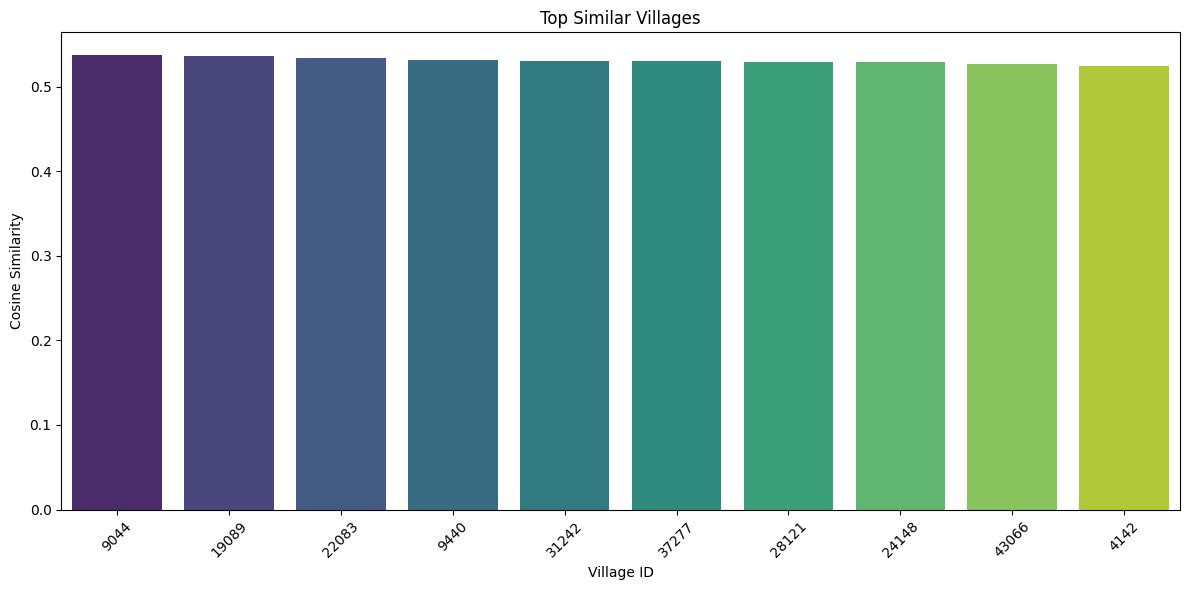

In [24]:
# Convert df_similarities to the ranked_villages format that ndcg_at_k expects
ranked_villages_from_df = list(zip(df_similarities['cmun'], df_similarities['similarity']))

# Calculate NDCG score for the recommendations
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

# Calculate NDCG at 10
ndcg_score = ndcg_at_k(ranked_villages_from_df, user_choices_cmun, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages_from_df[:10]:
    print(f"Village {village}: Similarity {score:.4f}")
    
# Optional: Add village names if available
if 'municipality' in df_pueblos.columns:
    # Create a lookup dictionary for village names
    cmun_to_name = dict(zip(df_pueblos['cmun'], df_pueblos['municipality']))
    
    print("\nTop 10 Most Similar Villages with Names:")
    for village, score in ranked_villages_from_df[:10]:
        village_name = cmun_to_name.get(village, "Unknown")
        print(f"Village {village} ({village_name}): Similarity {score:.4f}")

# Visualize top similarities with a bar chart
top_n = 10
village_ids = [str(v) for v, _ in ranked_villages_from_df[:top_n]]
similarity_scores = [score for _, score in ranked_villages_from_df[:top_n]]

plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
plt.title('Top Similar Villages')
plt.xlabel('Village ID')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Compute the Graph Density
Graph density tells us how connected the graph is.
A fully connected graph has density 1, while a sparse graph has density close to 0.

If density > 0.1, your graph might be too dense.
If density < 0.01, it might be too sparse.

### Draws the network graph

In [17]:
# import matplotlib.pyplot as plt
# import networkx as nx
# import numpy as np

# def plot_graph(G, figsize=(12, 10), node_size=50, sample=None, title="Village Network Graph"):
#     """
#     Plot the graph G with various visualization options.
    
#     Parameters:
#     - G: NetworkX graph
#     - figsize: Figure size tuple (width, height)
#     - node_size: Size of nodes in the plot
#     - sample: If provided, visualize only a sample of nodes (int or None)
#     - title: Plot title
#     """
#     # Create a copy to avoid modifying the original graph
#     if sample is not None and sample < len(G.nodes()):
#         # Sample nodes if the graph is too large
#         nodes = list(G.nodes())
#         sampled_nodes = np.random.choice(nodes, size=sample, replace=False)
#         H = G.subgraph(sampled_nodes)
#     else:
#         H = G.copy()
    
#     plt.figure(figsize=figsize)
    
#     # Choose a layout algorithm based on graph size
#     if len(H.nodes()) < 500:
#         pos = nx.spring_layout(H, seed=42)  # Force-directed layout
#     else:
#         pos = nx.kamada_kawai_layout(H)  # Better for larger graphs
    
#     # Get node degrees for sizing (optional)
#     node_degrees = dict(H.degree())
#     node_sizes = [node_size * (1 + 0.5 * node_degrees[n]) for n in H.nodes()]
    
#     # Draw the graph
#     nx.draw_networkx(
#         H,
#         pos=pos,
#         with_labels=False,  # Set to True for small graphs
#         node_size=node_sizes,
#         node_color="skyblue",
#         edge_color="gray",
#         alpha=0.8,
#         width=0.5
#     )
    
#     plt.title(title)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.show()
    
#     print(f"Graph visualization: {len(H.nodes())} nodes and {len(H.edges())} edges")
    

# # Basic usage
# plot_graph(G)

# # For large graphs, use a sample
# # plot_graph(G, sample=100, title="Sampled Village Network")

# # More detailed visualization
# def plot_detailed_graph(G, figsize=(14, 12), node_feature=None, highlight_nodes=None):
#     """
#     Create a more detailed graph visualization.
    
#     Parameters:
#     - G: NetworkX graph
#     - figsize: Figure size tuple
#     - node_feature: Dictionary with node values for coloring (optional)
#     - highlight_nodes: List of nodes to highlight (optional)
#     """
#     plt.figure(figsize=figsize)
    
#     # Sample the graph if it's very large
#     if len(G.nodes()) > 1000:
#         H = G.subgraph(np.random.choice(list(G.nodes()), 500, replace=False))
#     else:
#         H = G
    
#     pos = nx.spring_layout(H, seed=42)
    
#     # Node colors based on communities or other features
#     if node_feature:
#         node_colors = [node_feature.get(node, 0) for node in H.nodes()]
#         cmap = plt.cm.viridis
#         vmin = min(node_colors)
#         vmax = max(node_colors)
#     else:
#         # Default coloring
#         node_colors = 'skyblue'
#         cmap = None
#         vmin = vmax = None
    
#     # Basic nodes
#     nx.draw_networkx_nodes(
#         H, pos,
#         node_size=80,
#         node_color=node_colors,
#         cmap=cmap,
#         vmin=vmin,
#         vmax=vmax,
#         alpha=0.7
#     )
    
#     # Highlight specific nodes if provided
#     if highlight_nodes:
#         highlight_nodes = [n for n in highlight_nodes if n in H.nodes()]
#         if highlight_nodes:
#             nx.draw_networkx_nodes(
#                 H, pos,
#                 nodelist=highlight_nodes,
#                 node_size=150,
#                 node_color='red',
#                 edgecolors='black',
#                 linewidths=2
#             )
    
#     # Draw edges with reduced opacity
#     nx.draw_networkx_edges(
#         H, pos,
#         width=0.3,
#         alpha=0.4,
#         edge_color='gray'
#     )
    
#     # Add labels for a subset of nodes or important nodes
#     if len(H.nodes()) < 100:
#         nx.draw_networkx_labels(H, pos, font_size=8)
    
#     plt.title("Village Network Visualization", fontsize=16)
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Example usage with highlight_nodes
# top_villages = [v[0] for v in ranked_villages[:5]]  # Top 5 villages from previous results
# plot_detailed_graph(G, highlight_nodes=top_villages)